# 6주차 과제 복습 by 이찬송, 김수한


In [ ]:
# 지도 라이브러리(folium) 설치 확인
import folium

In [ ]:
# 서울 지하철 시간대별 승하차 인원 데이터 읽어오기

import pandas as pd
data = pd.read_csv('seoul-metro-2021.logs.csv')
data.head()

In [ ]:
# 서울 지하철역 정보 데이터 읽어오기
station_info = pd.read_csv('seoul-metro-station-info.csv')
station_info.head()

### 3. 데이터 가공 1

In [ ]:
# 승차인원 데이터 상세 정보 확인하기
# tiomestamp : 시간
# station_code : 역 코드
# people_in : 승차인원
# people_out : 하차인원

data.info()

In [ ]:
# 지하철 역 데이터 상세 정보 확인하기
# station_code : 역 코드
# geo.latitude : 지하철역 위도
# geo.longitude : 지하철역 경도

station_info.info()

In [ ]:
# 필요한 변수만 고르기
station_info = station_info[['station.code', 'geo.latitude', 'geo.longitude', 'station.name']]
station_info

In [ ]:
# 승하차 데이터와 색인 맞추기
station_info = station_info.set_index('station.code')
station_info

### 과제 1
1. 11시부터 2시 사이에 승차인원이 가장 많은 3개는 어디인가 ?
2. 11시부터 2시 사이에 하차인원이 가장 많은 3개는 어디인가 ?

In [ ]:
# 출근 데이터 추출을 위한 시간 변수 추가
data['hour'] = pd.to_datetime(data['timestamp']).dt.hour
data.head()

In [ ]:
lunch_data = data.query('hour > 11' and 'hour < 14')
lunch_data

In [ ]:
lunch_station_sum = lunch_data.groupby('station_code')[['people_in', 'people_out']].sum()
lunch_station_sum

In [ ]:
lunch_joined_data = lunch_station_sum.join(station_info)
lunch_joined_data.head()

In [ ]:
# 11시부터 2시 사이에 승차인원이 가장 많은 3개는 어디인가 ?
lunch_joined_data.sort_values(by='people_in', ascending=False).head(3)[['station.name', 'people_in']]

In [ ]:
# 11시부터 2시 사이에 하차인원이 가장 많은 3개는 어디인가 ?
lunch_joined_data.sort_values(by='people_out', ascending=False).head(3)[['station.name', 'people_out']]

## 과제 2
1. 과제 1에서 가공한 데이터를 가지고 히트맵 대신 조건에 맞는 역에 동그라미를 그려보자
2. folium에서 지도에 동그라미를 그리는 클래스는 Circle임
3. 점심시간에 하차인원이 250만명이 넘는 역만 표시
4. 동그라미 테두리는 붉은색, 내부는 붉은색으로 채운다
5. 동그라미 반지름은 하차인원의 0.01%로 그린다.

In [ ]:
from folium.plugins import HeatMap

In [ ]:
# 점심시간 하차인원이 2500000명 이상인 데이터만 추출
filtered_data_out = lunch_joined_data[lunch_joined_data['people_out'] > 2500000]
filtered_data_out

In [ ]:
filtered_data_out = filtered_data_out.copy()
filtered_data_out['radius'] = filtered_data_out['people_out'] * 0.0001
filtered_data_out = filtered_data_out.reset_index()
filtered_data_out

In [ ]:
afternoon_seoul = folium.Map(location=[37.55, 126.98], zoom_start=12)

# 데이터프레임이 각 행에 대해 처리 : index와 각 행 데이터(row)를 반환한다.
# 성능이 떨어짐 - apply() 활용이 효율적
for index, row in filtered_data_out.iterrows():
    folium.Circle(
        location=[row['geo.latitude'], row['geo.longitude']],
        radius=row['radius'],
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        tooltip=row['station_code']
    ).add_to(afternoon_seoul)

afternoon_seoul

In [ ]:
afternoon_seoul = folium.Map(location=[37.55, 126.98], zoom_start=12)

def apply_map(row) :
    folium.Circle(
        location=[row['geo.latitude'], row['geo.longitude']],
        radius=row['radius'],
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        tooltip=row['station_code']
    ).add_to(afternoon_seoul)

# 데이터프레임의 각 행에 대해 apply_map() 함수 적용 - 성능이 향상
filtered_data_out.apply(apply_map, axis=1)

afternoon_seoul

# 도전과제 - streamlit으로 웹 배포
1. 승하차 시간대를 선택하여 분석할 수 있도록 제작
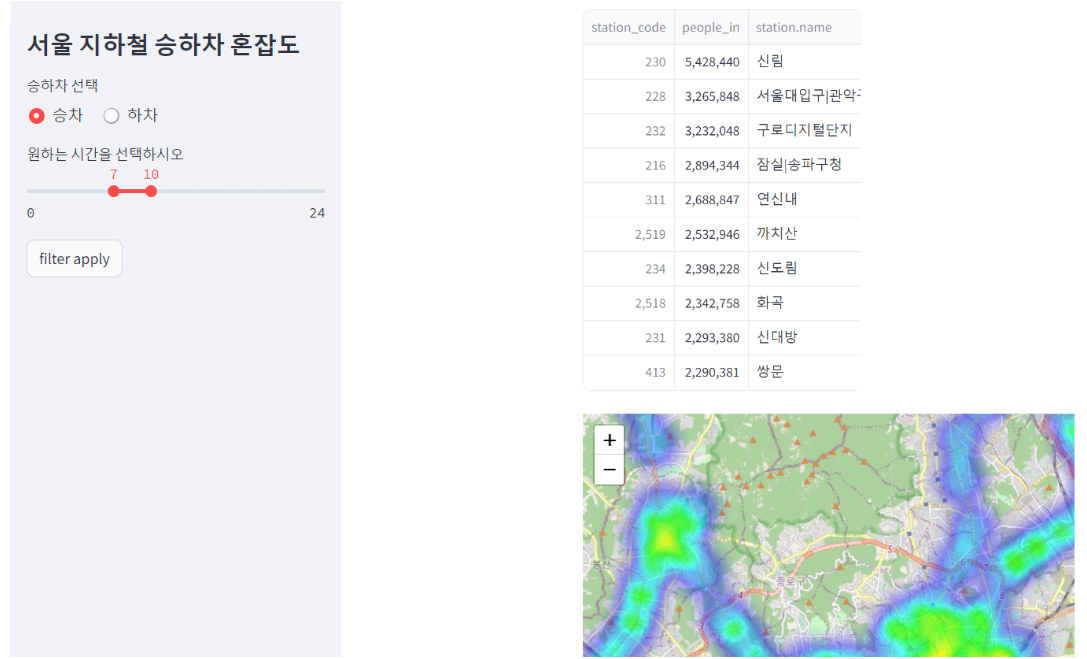

```
import pandas as pd
import folium
import streamlit as st
from streamlit_folium import st_folium
from folium.plugins import HeatMap

# 서울 지하철 시간대별 승하차 인원 데이터 읽어오기
data = pd.read_csv('seoul-metro-2021.logs.csv')
data['hour'] = pd.to_datetime(data['timestamp']).dt.hour

# 서울 지하철 역 정보 데이터 읽어오기
station_info = pd.read_csv('seoul-metro-station-info.csv')


# sidebar 만들기
st.sidebar.title('서울 지하철 승하차 혼잡도')

# radio box
select = st.sidebar.radio('승하차 선택', ['승차', '하차'], horizontal=True)

# slide bar 생성
select_range = st.sidebar.slider("원하는 시간을 선택하시오", min_value=0, max_value=24, value=(0, 24))
start_hour, end_hour = select_range

# filter start button
start = st.sidebar.button('filter apply')

# 승차인원 분석 시간대 적용
hour_data = data.query('(hour > @start_hour) & (hour < @end_hour)')

# 역 기준으로 승차인원 합치기
# 숫자 타입이 아닌 timestamp는 사라짐
station_sum = hour_data.groupby('station_code')[['people_in', 'people_out']].sum()

# 필요한 변수만 고르기
station_info = station_info[['station.code', 'geo.latitude', 'geo.longitude', 'station.name']]

# 승하차 데이터와 색인 맞추기
station_info = station_info.set_index('station.code')

# 승하차 인원 데이터와 지하철역 정보 데이터 합치기
# 색인을 기준으로 데이터 합치기 : join()
joined_data = station_sum.join(station_info)
    
# 승차 인원 시각화 (승차용 서울지도 만들기)
seoul = folium.Map(location=[37.55, 126.98], zoom_start = 12)

if start:
    if select == '승차' :
        HeatMap(data=joined_data[['geo.latitude', 'geo.longitude','people_in']]).add_to(seoul)
        st.write(joined_data.sort_values(by='people_in', ascending=False).head(10)[['people_in', 'station.name']])

    elif select == '하차' :
        HeatMap(data=joined_data[['geo.latitude', 'geo.longitude','people_out']]).add_to(seoul)
        st.write(joined_data.sort_values(by='people_out', ascending=False).head(10)[['people_out', 'station.name']])
    else :
        st.write("ELSE")

    st_folium(seoul, returned_objects=[])
```